<a href="https://colab.research.google.com/github/wangyaomoon/Cooling-Stage/blob/main/Chromatix_3D_Holography_VaziriLab_A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import jax
import jax.numpy as jnp
import optax
from einops import rearrange
from jax import random
from chex import Array
import imageio
import matplotlib.pyplot as plt
from PIL import Image


from chromatix import Field
from chromatix.functional import *
from chromatix.utils import flat_phase
from chromatix.ops import quantize

import os
from datetime import datetime
from typing import Any, Callable, Optional, Sequence, Tuple

# from google.colab import drive
# drive.mount('/content/drive')
# # Path to directory in Google Drive
# base_dir = '/content/drive/My Drive/ColabFiles/SLMImages'
base_dir = r'C:\Users\wang6\Dropbox (Vaziri)\Project-SLM_Holography\Chromatix_Holography\Simulation'
# Create the directory if it doesn't exist
if not os.path.exists(base_dir):
    os.makedirs(base_dir)

from datetime import datetime

In [ ]:
def forward(
    phase: Array,
    z: Array,
    focal_length: float,
    refractive_index: float,
    pixel_size: float,
    spectrum: float,
    spectral_density: float,
    amplitude: Array,
) -> Field:
    field = plane_wave(phase.shape, pixel_size, spectrum, spectral_density)
    field = amplitude_change(field, amplitude)
    field = phase_change(field, quantize(phase, 8))
    field = ff_lens(field, focal_length, refractive_index)
    field = asm_propagate(field, z, refractive_index, 0)
    return field

In [ ]:
def backward(
    field: Field,
    z: Array,
    focal_length: float,
    refractive_index: float,
) -> Field:
    field = asm_propagate(field, -z, refractive_index, 0)
    field = ff_lens(field, -focal_length, refractive_index)
    return field

In [ ]:
def gradient_descent(
    num_iterations: int,
    target_pattern: Array,
    z: Array,
    focal_length: float,
    refractive_index: float,
    pixel_size: float,
    spectrum: float,
    spectral_density: float,
    beam_amplitude: Array,
    learning_rate: float = 1e-3,
) -> Array:
    assert target_pattern.ndim == 3, "Target pattern should be a 3D array of shape (z, y, x)"
    z = jnp.atleast_1d(z)
    phase = jnp.angle(jnp.fft.fftshift(jnp.fft.ifft2(jnp.fft.ifftshift(jnp.sum(target_pattern, axis=0), axes=(0, 1))), axes=(0, 1)))
    optimizer = optax.adam(learning_rate)
    optimizer_state = optimizer.init(phase)

    def _loss(phase: Array, target_pattern: Array) -> Array:
        field_at_image = forward(phase, z, focal_length, refractive_index, pixel_size, spectrum, spectral_density, beam_amplitude)
        loss = 1.0 - jnp.corrcoef(target_pattern.ravel(), field_at_image.intensity.squeeze().ravel())[0, 1]
        return loss

    @jax.jit
    def _step(phase: Array, target_pattern: Array, optimizer_state: Array) -> Array:
        loss, grads = jax.value_and_grad(_loss)(phase, target_pattern)
        updates, optimizer_state = optimizer.update(grads, optimizer_state)
        phase = optax.apply_updates(phase, updates)
        return phase, loss, optimizer_state

    for i in range(num_iterations):
        phase, loss, optimizer_state = _step(phase, target_pattern, optimizer_state)
        print(f"iteration {i + 1} / {num_iterations} loss = {loss}")
    return phase

**Setup important parameters for simulation**

Note unit are um for thickness, space, length

In [ ]:
field_size = 1080
shape = (field_size, field_size) # the field shape for simulation
pixel_size = 8 # pixel size of SLM and the field
focal_length = 200e3
refractive_index = 1 # air is 1, water is 1.33
spectrum: float = 1.03
spectral_density = 1,
z_range = 10000
slice_num = 30
spot_num = 1000
FWHM = 8000 # beam diameter represented by FWHM

**Based on the above parametes, calculate important number for later simulation**

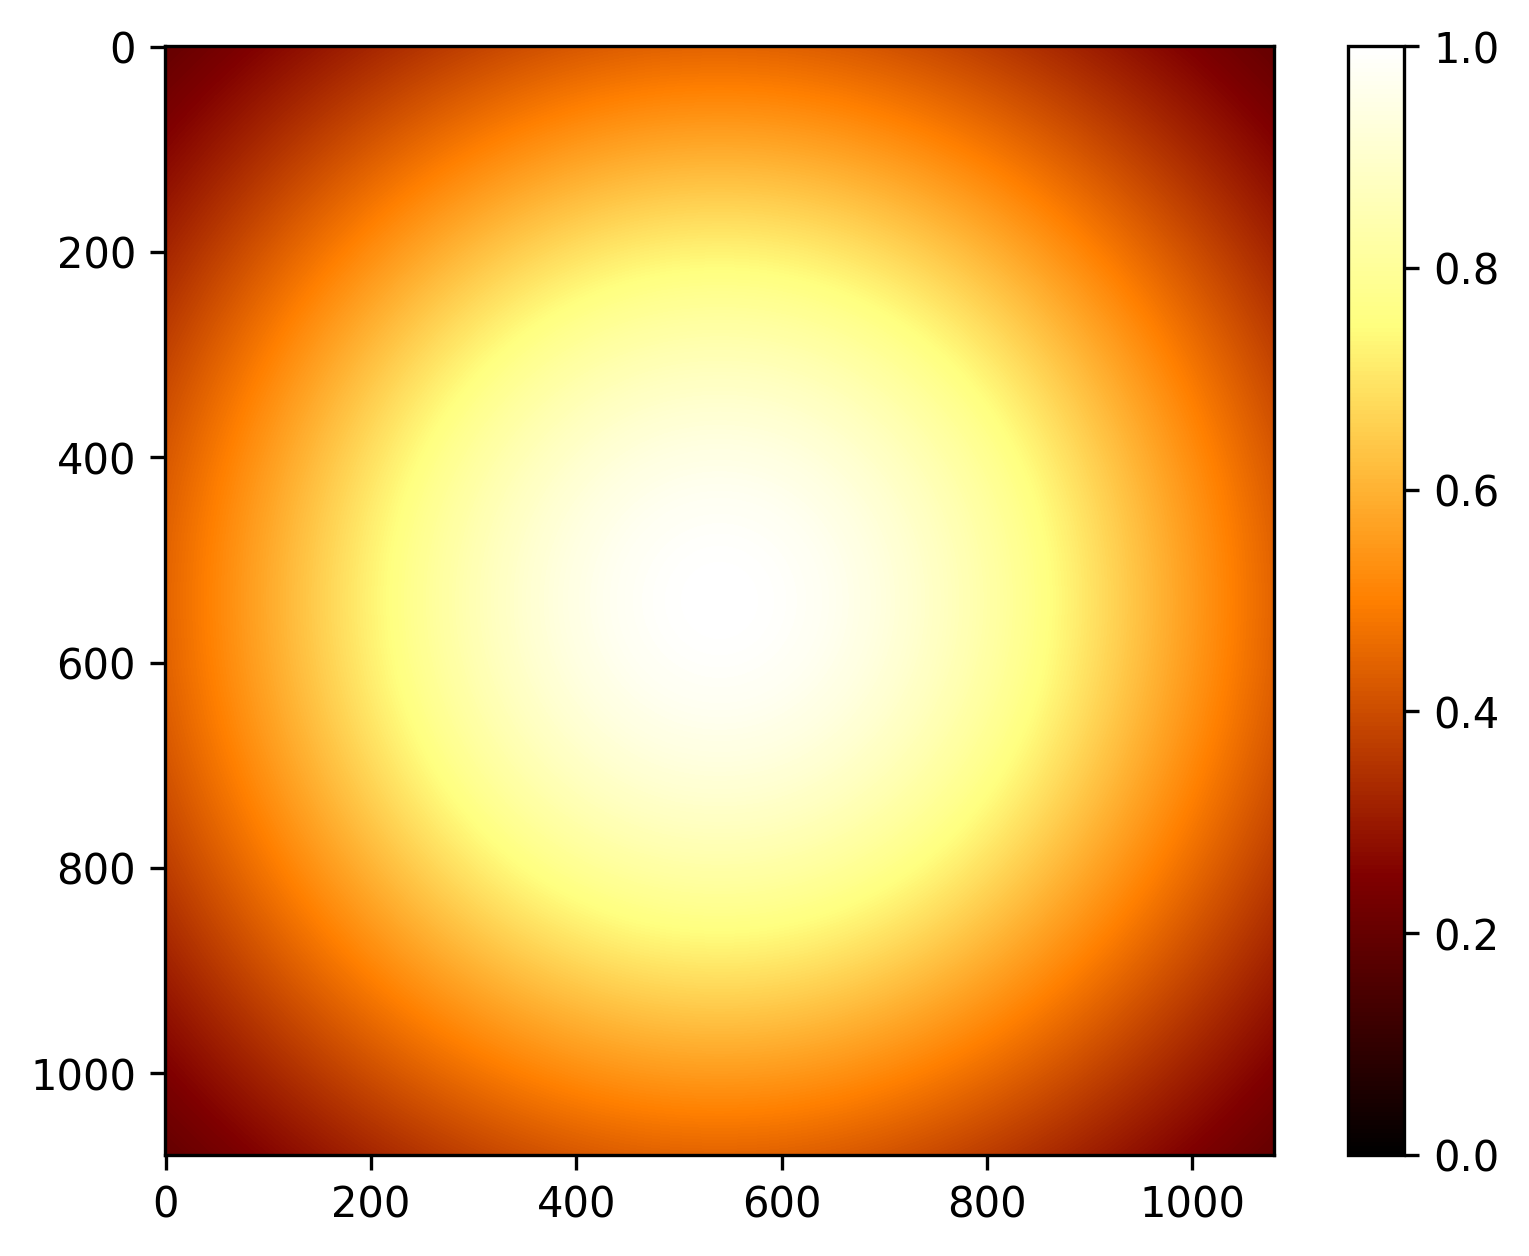

In [ ]:
field_dimension = field_size * pixel_size
sigma = FWHM / (2 * np.sqrt(2 * np.log(2)))
x = np.linspace(-field_dimension/ 2, field_dimension / 2, field_size)
y = np.linspace(-field_dimension / 2, field_dimension / 2, field_size)
x, y = np.meshgrid(x, y)
gaussian = np.exp(-((x**2 + y**2) / (2 * sigma**2)))
gaussian_max = np.max(gaussian)

beam_amplitude = gaussian / gaussian_max

plt.figure(dpi=300)
plt.imshow(beam_amplitude, vmin=0, vmax=1, cmap="afmhot")
plt.colorbar()
plt.show()

### We can learn a 3D pattern using gradient descent

Here, we'll try using gradient descent to retrieve a 3D pattern where the top half of the 2D target is in focus at the focal plane and the bottom half of the 2D target is in focus after 2500 um.

In [ ]:
# create a matrix that contains several spots
z = jnp.linspace(0, z_range, slice_num, endpoint=True)
sample = np.zeros((z.size, *shape))

central_area_dim = (shape[0]/2,shape[1]/2) # reduce the area to central area
sample_centralArea = np.zeros((int(slice_num), int(shape[0]/2),int(shape[1]/2))) # Pass the dimensions as a tuple
flattened_sample_centralArea = sample_centralArea.flatten()

random_indices = np.random.choice(flattened_sample_centralArea.size, spot_num, replace=False)

# Place ones in the randomly chosen positions
flattened_sample_centralArea[random_indices] = 1

# Reshape the flattened array back to its original shape
sample_centralArea = flattened_sample_centralArea.reshape(sample_centralArea.shape)

# place the small central area to the bigger original shape area
# Convert start_x and start_y to integers
start_x = int((shape[0] - central_area_dim[0]) // 2)
start_y = int((shape[1] - central_area_dim[1]) // 2)

sample[:, start_x:start_x+int(central_area_dim[0]), start_y:start_y+int(central_area_dim[1])] = sample_centralArea
target_pattern_3d = jnp.array(sample)

## Start the Gradient decent iteration to achieve a possible mask

In [ ]:
learned_phase = gradient_descent(20, target_pattern_3d, jnp.linspace(0, z_range, slice_num), focal_length, refractive_index, pixel_size, spectrum,spectral_density, beam_amplitude, learning_rate=1e-2)

In [ ]:
plt.figure(dpi=300)
plt.imshow(learned_phase, vmin=-np.pi, vmax=np.pi, cmap="hsv")
plt.colorbar()
plt.show()

## Verify the phase mask generated target is similar to our target

In [ ]:
learned_intensity = forward(learned_phase, jnp.linspace(0, z_range, slice_num)).intensity.squeeze()

fig, axes = plt.subplots(ncols=2, dpi=600)
h = axes[0].imshow(learned_intensity[0], cmap="gray", interpolation="nearest")
axes[0].set_title(f"focal plane")
fig.colorbar(h, fraction=0.046)
h = axes[1].imshow(learned_intensity[10], cmap="gray", interpolation="nearest")
axes[1].set_title(f"after 2500 um")
fig.colorbar(h, fraction=0.046)
h = axes[2].imshow(learned_intensity[10], cmap="gray", interpolation="nearest")
axes[1].set_title(f"after 2500 um")
fig.colorbar(h, fraction=0.046)

plt.tight_layout()
fig.show()

## save the phase mask, target, verified target, and log file

In [ ]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

learned = learned_intensity.astype(np.float32)
learned = (learned - np.min(learned)) / (np.max(learned) - np.min(learned))
learned = np.round(learned * 65535)
learned = learned.astype(np.uint16)

learned = np.array(learned)

z_range = 10000
z_range_in_mm = int(z_range/1000)
# Save the image as a TIFF file
output_path = f'{base_dir}/{timestamp}_SelfVerifiedImageStack_ZRange{z_range_in_mm}mm.tiff'
# full_filename = f'{timestamp}_ChromatixVerifiedImageStack_ZRange{z_range/1000}mm_SpotDia{diameter}um.tiff'
# tiff_image = Image.fromarray(learned[0])
# tiff_image.save(full_filename, save_all=True, append_images=[Image.fromarray(learned[i]) for i in range(1, learned.shape[0])])
# files.download(full_filename)
imageio.mimwrite(output_path, learned, format='TIFF')



# After training, extract the trained phase mask matrix
phase_mask_matrix = learned_phase
normalized_phase_mask = phase_mask_matrix % (2 * np.pi)
# Normalize the phase mask matrix for saving as an image
# normalized_phase_mask = phase_mask_matrix.astype(np.float32)

normalized_phase_mask = (normalized_phase_mask - np.min(normalized_phase_mask)) / (np.max(normalized_phase_mask) - np.min(normalized_phase_mask))
normalized_phase_mask = np.round(normalized_phase_mask * 255)
normalized_phase_mask = normalized_phase_mask.astype(np.uint8)

# Save the phase mask matrix as a bmp file
# full_filename = f'{timestamp}_ChromatixTrainedPhaseMask_ZRange{z_range/1000}mm_SpotDia{diameter}um.bmp'
# plt.imsave(full_filename, normalized_phase_mask, cmap='gray')  # Save the grayscale image
output_path = f'{base_dir}/{timestamp}_TrainedPhaseMask_ZRange{z_range_in_mm}mm.bmp'
imageio.imwrite(output_path, normalized_phase_mask)

